# Imports

In [1]:
%load_ext autoreload
%autoreload 2

%matplotlib inline

In [2]:
import numpy as np
import pandas as pd
import lightgbm as lgb
from sklearn.model_selection import train_test_split

import matplotlib.pyplot as plt


import sys
import os
# add library module to PYTHONPATH
sys.path.append(f"{os.getcwd()}/../")

from dtreeviz import trees
from dtreeviz.models.lightgbm_decision_tree import ShadowLightGBMTree


# Load and prepare dataset

In [3]:
dataset = pd.read_csv("../data/titanic/titanic.csv")

In [4]:
dataset

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S
...,...,...,...,...,...,...,...,...,...,...,...,...
886,887,0,2,"Montvila, Rev. Juozas",male,27.0,0,0,211536,13.0000,NaN,S
887,888,1,1,"Graham, Miss. Margaret Edith",female,19.0,0,0,112053,30.0000,B42,S
888,889,0,3,"Johnston, Miss. Catherine Helen ""Carrie""",female,NaN,1,2,W./C. 6607,23.4500,NaN,S
889,890,1,1,"Behr, Mr. Karl Howell",male,26.0,0,0,111369,30.0000,C148,C


In [5]:
dataset.fillna({"Age":dataset.Age.mean()}, inplace=True)
# Encode categorical variables
dataset["Sex_label"] = dataset.Sex.astype("category").cat.codes
dataset["Cabin_label"] = dataset.Cabin.astype("category").cat.codes
dataset["Embarked_label"] = dataset.Embarked.astype("category").cat.codes

# Classification

## Datasets

In [7]:
features = ["Pclass", "Age", "Fare", "Sex_label", "Cabin_label", "Embarked_label"]
target = "Survived"

X_train, X_test, y_train, y_test = train_test_split(dataset[features], dataset[target], test_size=0.2, random_state=42)

train_data = lgb.Dataset(data=X_train, label=y_train)
valid_data = lgb.Dataset(data=X_test, label=y_test)

## Model training

In [8]:
lgbm_params = {
    'boosting': 'dart',          # dart (drop out trees) often performs better
    'application': 'binary',     # Binary classification
    'learning_rate': 0.05,       # Learning rate, controls size of a gradient descent step
    'min_data_in_leaf': 22,      # Data set is quite small so reduce this a bit
    'feature_fraction': 0.7,     # Proportion of features in each boost, controls overfitting
    'num_leaves': 41,            # Controls size of tree since LGBM uses leaf wise splits
    'drop_rate': 0.15,
    'max_depth':4,
    "seed":1212}

lgbm_model = lgb.train(lgbm_params, train_data, valid_sets=[train_data, valid_data])

[LightGBM] [Info] Number of positive: 268, number of negative: 444
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000900 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 233
[LightGBM] [Info] Number of data points in the train set: 712, number of used features: 6
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.376404 -> initscore=-0.504838
[LightGBM] [Info] Start training from score -0.504838
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1]	training's binary_logloss: 0.641119	valid_1's binary_logloss: 0.658611
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[2]	training's binary_logloss: 0.622109	valid_1's binary_logloss: 0.638123
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[3]	training's binary_logloss: 0.613812	valid_1's binary_logloss: 0.6288

## LightGBM default visualisations

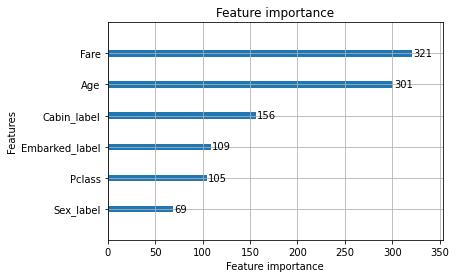

In [9]:
lgb.plot_importance(lgbm_model)

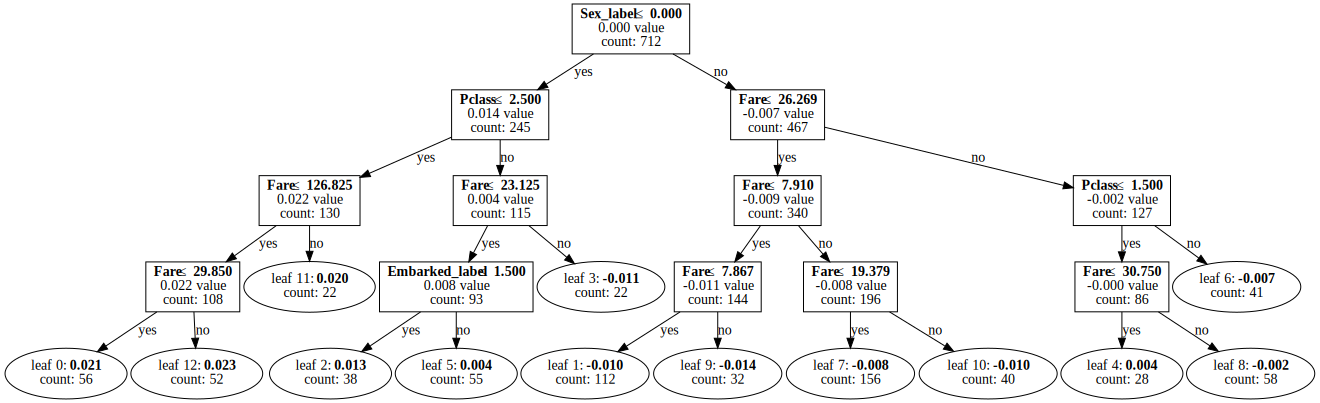

In [10]:
lgb.create_tree_digraph(lgbm_model, tree_index=1,  orientation = "vertical", show_info=['internal_count', 'leaf_count', 'internal_value'])


## dtreeviz visualizations

In [11]:
# lgbm_model.save_model("../testing/dtreeviz/models/fixtures/lightgbm_model_classifier.txt")
# lgbm = lgb.Booster(model_file="../testing/dtreeviz/models/fixtures/lightgbm_model_classifier.txt")

In [12]:
light_dtree = ShadowLightGBMTree(lgbm_model, tree_index=1, x_data=X_train, y_data=y_train, feature_names=features, target_name=target, class_names=[0,1] )


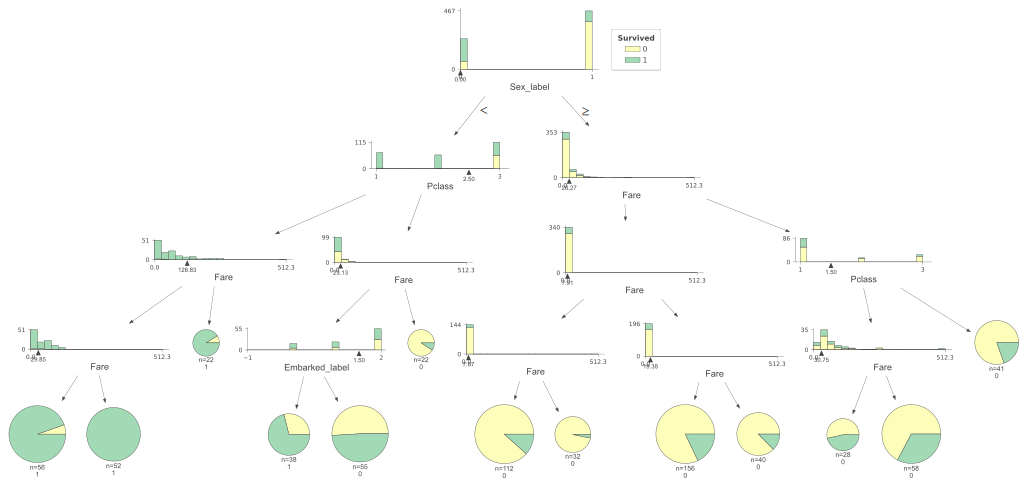

In [13]:
trees.dtreeviz(light_dtree)

Pclass             3.000
Age               32.000
Fare               7.925
Sex_label          1.000
Cabin_label       -1.000
Embarked_label     2.000
Name: 382, dtype: float64


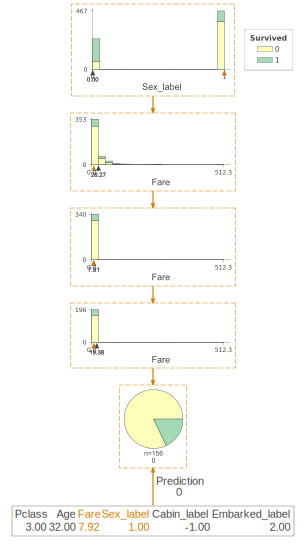

In [14]:
x = X_train[features].iloc[2]
print(x)
trees.dtreeviz(light_dtree, X=x, show_just_path=True)

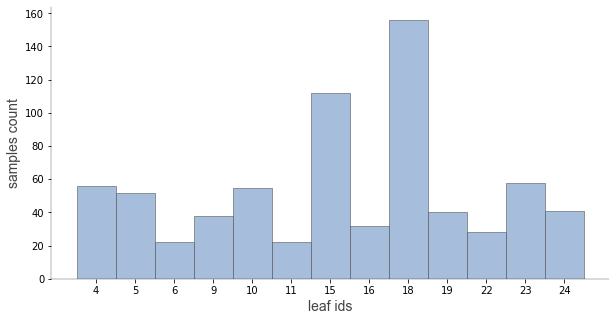

In [15]:
trees.viz_leaf_samples(light_dtree)

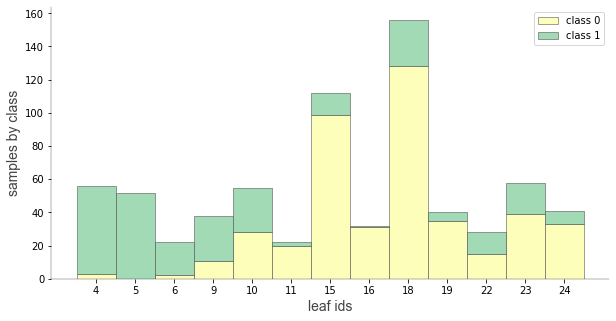

In [16]:
trees.ctreeviz_leaf_samples(light_dtree)

In [17]:
trees.describe_node_sample(light_dtree, node_id=5)

,Pclass,Age,Fare,Sex_label,Cabin_label,Embarked_label
count,52.000000,52.000000,52.000000,52.0,52.000000,52.000000
mean,1.153846,32.386488,69.992229,0.0,53.942308,1.057692
std,0.364321,13.851534,23.279059,0.0,45.287064,1.055582
min,1.000000,3.000000,30.000000,0.0,-1.000000,-1.000000
25%,1.000000,22.750000,53.100000,0.0,17.000000,0.000000
50%,1.000000,31.500000,70.150000,0.0,47.000000,2.000000
75%,1.000000,39.000000,83.237475,0.0,88.250000,2.000000
max,2.000000,62.000000,120.000000,0.0,144.000000,2.000000


In [18]:
x = X_train[features].iloc[10]
x

Pclass             2.0
Age               42.0
Fare              13.0
Sex_label          0.0
Cabin_label       -1.0
Embarked_label     2.0
Name: 865, dtype: float64

In [19]:
print(trees.explain_prediction_path(light_dtree, x=x))

Pclass < 2.5
Fare < 29.85
0.0 <= Sex_label 



# Regression

## Datasets

In [20]:
features_reg = ["Pclass", "Survived", "Fare", "Sex_label", "Cabin_label", "Embarked_label"]
target_reg = "Age"

X_train_reg, X_test_reg, y_train_reg, y_test_reg = train_test_split(dataset[features_reg], dataset[target_reg], test_size=0.2, random_state=42)

train_data_reg = lgb.Dataset(data=X_train_reg, label=y_train_reg)
valid_data_reg = lgb.Dataset(data=X_test_reg, label=y_test_reg)

lgbm_params = {
    'num_tree':10,
    'boosting': 'dart',          # dart (drop out trees) often performs better
    'application': 'regression_l1',     
    'learning_rate': 0.05,       # Learning rate, controls size of a gradient descent step
    'min_data_in_leaf': 20,      # Data set is quite small so reduce this a bit
    'feature_fraction': 0.7,     # Proportion of features in each boost, controls overfitting
    'num_leaves': 41,            # Controls size of tree since LGBM uses leaf wise splits
    'drop_rate': 0.15,
    'max_depth':4,
    "seed":1212}


## Model training

In [21]:
lgbm_reg_model = lgb.train(lgbm_params, train_data_reg, valid_sets=[train_data_reg, valid_data_reg])

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000612 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 175
[LightGBM] [Info] Number of data points in the train set: 712, number of used features: 6
[LightGBM] [Info] Start training from score 29.699118
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1]	training's l1: 9.03156	valid_1's l1: 9.05193
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[2]	training's l1: 9.00275	valid_1's l1: 9.03197
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[3]	training's l1: 8.96288	valid_1's l1: 9.01286
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[4]	training's l1: 8.96182	valid_1's l1: 9.01891
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[5]	training's l1: 8.92

/Users/tudorl/Documents/workspace/personal/dtreeviz/venv/lib/python3.7/site-packages/lightgbm/engine.py:151: UserWarning: Found `num_tree` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


## LightGBM default visualisations

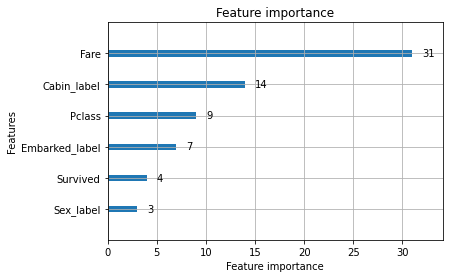

In [22]:
lgb.plot_importance(lgbm_reg_model)

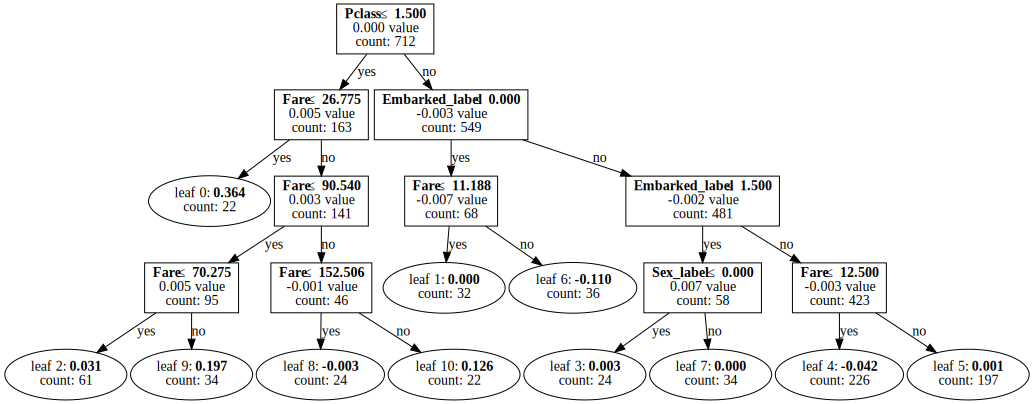

In [23]:
lgb.create_tree_digraph(lgbm_reg_model, tree_index=1,  orientation = "vertical", show_info=['internal_count', 'leaf_count', 'internal_value'])


## dtreeviz visualisations

In [24]:
light_dtree_reg = ShadowLightGBMTree(lgbm_reg_model, tree_index=1, x_data=X_train_reg, y_data=y_train_reg, feature_names=features_reg, target_name=target_reg)


/Users/tudorl/Documents/workspace/personal/dtreeviz/venv/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3335: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/Users/tudorl/Documents/workspace/personal/dtreeviz/venv/lib/python3.7/site-packages/numpy/core/_methods.py:161: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


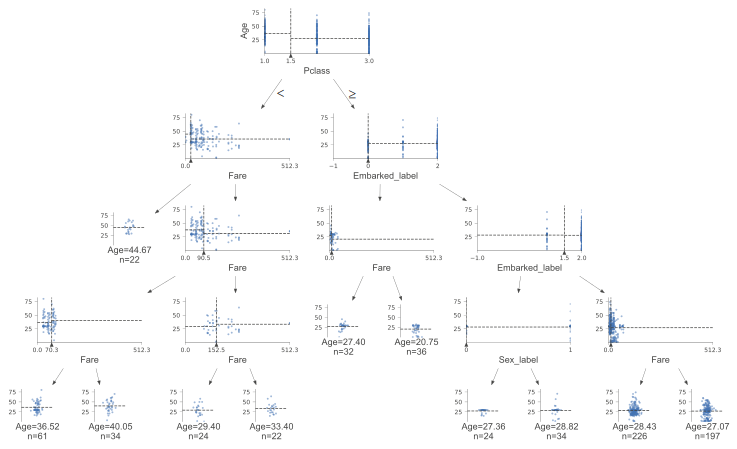

In [25]:
trees.dtreeviz(light_dtree_reg)

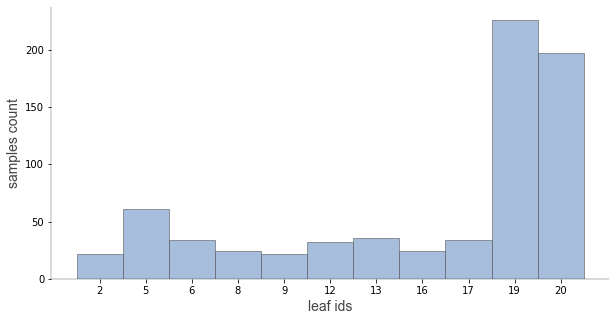

In [26]:
trees.viz_leaf_samples(light_dtree_reg)

In [27]:
trees.describe_node_sample(light_dtree_reg, node_id=19)

,Pclass,Survived,Fare,Sex_label,Cabin_label,Embarked_label
count,226.000000,226.000000,226.000000,226.000000,226.000000,226.0
mean,2.884956,0.203540,8.125402,0.809735,4.876106,2.0
std,0.319784,0.403524,2.053144,0.393382,27.495982,0.0
min,2.000000,0.000000,0.000000,0.000000,-1.000000,2.0
25%,3.000000,0.000000,7.775000,1.000000,-1.000000,2.0
50%,3.000000,0.000000,7.925000,1.000000,-1.000000,2.0
75%,3.000000,0.000000,8.662500,1.000000,-1.000000,2.0
max,3.000000,1.000000,12.475000,1.000000,145.000000,2.0


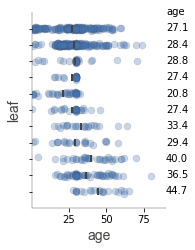

In [28]:
trees.viz_leaf_target(light_dtree_reg)

In [29]:
x = X_train_reg[features_reg].iloc[20]
x

Pclass             3.000
Survived           0.000
Fare              31.275
Sex_label          0.000
Cabin_label       -1.000
Embarked_label     2.000
Name: 542, dtype: float64

/Users/tudorl/Documents/workspace/personal/dtreeviz/venv/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3335: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/Users/tudorl/Documents/workspace/personal/dtreeviz/venv/lib/python3.7/site-packages/numpy/core/_methods.py:161: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


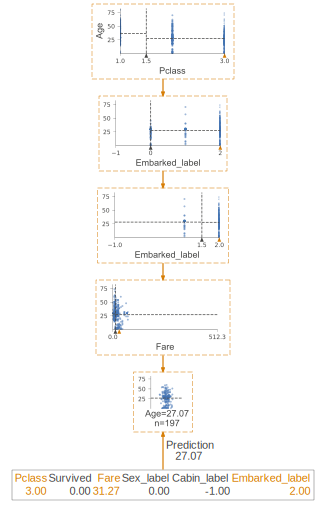

In [30]:
trees.dtreeviz(light_dtree_reg, X=x, show_just_path=True)

In [31]:
print(trees.explain_prediction_path(light_dtree_reg, x))

1.5 <= Pclass 
12.5 <= Fare 
1.5 <= Embarked_label 

